In [1]:
# =============================================================================
# PHẦN 1: TIỀN XỬ LÝ & TẠO FILE DỮ LIỆU GỘP (MERGED FILE)
# =============================================================================

import pandas as pd
import numpy as np

print("⏳ ĐANG TẢI VÀ XỬ LÝ DỮ LIỆU THÔ...")

# 1. Load dữ liệu gốc
try:
    df_objects = pd.read_csv("objects.csv", low_memory=False)
    df_funding = pd.read_csv("funding_rounds.csv", low_memory=False)
except FileNotFoundError:
    print("❌ Lỗi: Không tìm thấy file csv gốc.")
    exit()

# 2. Xử lý bảng Funding (Gom nhóm dữ liệu gọi vốn)
funding_cols = ['object_id', 'raised_amount_usd', 'funded_at']
df_funding = df_funding[funding_cols].copy()

# Chuyển đổi và làm sạch
df_funding['raised_amount_usd'] = pd.to_numeric(df_funding['raised_amount_usd'], errors='coerce')
df_funding['funded_at'] = pd.to_datetime(df_funding['funded_at'], errors='coerce')
df_funding = df_funding.dropna(subset=['raised_amount_usd', 'funded_at'])

# Gom nhóm (Aggregation): Biến nhiều dòng funding thành 1 dòng tổng hợp
funding_agg = df_funding.groupby('object_id').agg({
    'raised_amount_usd': ['sum', 'count'],  # Tổng tiền, Số vòng
    'funded_at': ['min', 'max']             # Ngày đầu, Ngày cuối
}).reset_index()

# Đổi tên cột cho rõ ràng
funding_agg.columns = ['object_id', 'total_raised_usd', 'funding_rounds_count', 'first_funding_date', 'last_funding_date']

# Tính thời gian duy trì gọi vốn (Feature Engineering)
funding_agg['days_between_first_last_funding'] = (funding_agg['last_funding_date'] - funding_agg['first_funding_date']).dt.days

# 3. Xử lý bảng Objects
df_objects = df_objects[df_objects['entity_type'] == 'Company'].copy()
cols_obj = ['id', 'name', 'category_code', 'status', 'country_code', 'founded_at']
df_objects = df_objects[cols_obj].rename(columns={'id': 'object_id'})

# Tính tuổi công ty (Tính đến 2014)
df_objects['founded_at'] = pd.to_datetime(df_objects['founded_at'], errors='coerce')
df_objects['company_age_days'] = (pd.to_datetime('2014-01-01') - df_objects['founded_at']).dt.days
df_objects = df_objects[df_objects['company_age_days'] > 0] # Lọc dữ liệu lỗi


# 4. MERGE (GỘP) TẠO DATASET CUỐI CÙNG
df_master = pd.merge(df_objects, funding_agg, on='object_id', how='left')

# Điền 'Unknown' cho quốc gia bị thiếu
df_master['country_code'] = df_master['country_code'].fillna('Unknown')  # <--- Dòng quan trọng

# Điền 0 cho những công ty không gọi vốn
df_master['total_raised_usd'] = df_master['total_raised_usd'].fillna(0)
df_master['funding_rounds_count'] = df_master['funding_rounds_count'].fillna(0)
df_master['status'] = df_master['status'].fillna('unknown')

# 5. XUẤT FILE MỚI (QUAN TRỌNG)
output_filename = 'startup_data_merged.csv'
df_master.to_csv(output_filename, index=False)

print(f"✅ ĐÃ TẠO THÀNH CÔNG FILE: {output_filename}")
print(f"   Kích thước dữ liệu: {df_master.shape}")
print("-" * 60)

⏳ ĐANG TẢI VÀ XỬ LÝ DỮ LIỆU THÔ...
✅ ĐÃ TẠO THÀNH CÔNG FILE: startup_data_merged.csv
   Kích thước dữ liệu: (91211, 12)
------------------------------------------------------------


📂 ĐANG ĐỌC FILE 'startup_data_merged.csv'...
✅ Đã tải xong. Sẵn sàng phân tích 91211 dòng dữ liệu.

📊 ĐANG VẼ 6 BIỂU ĐỒ EDA...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_9188\3551727074.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')


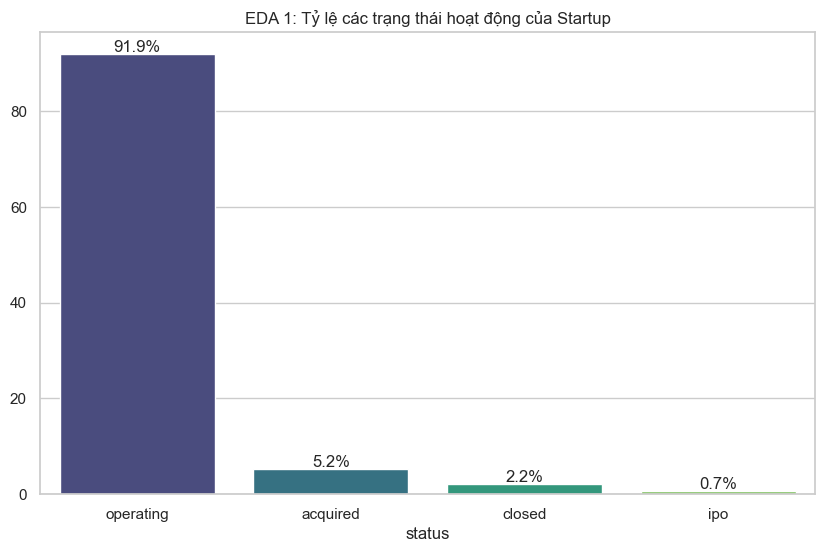

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9188\3551727074.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='category_code', order=top_categories, palette='magma')


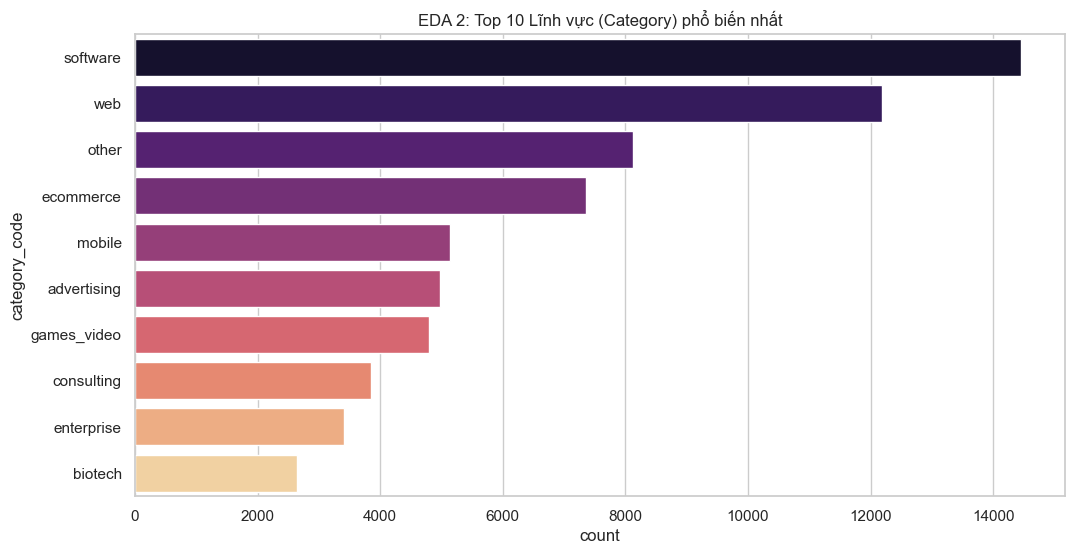

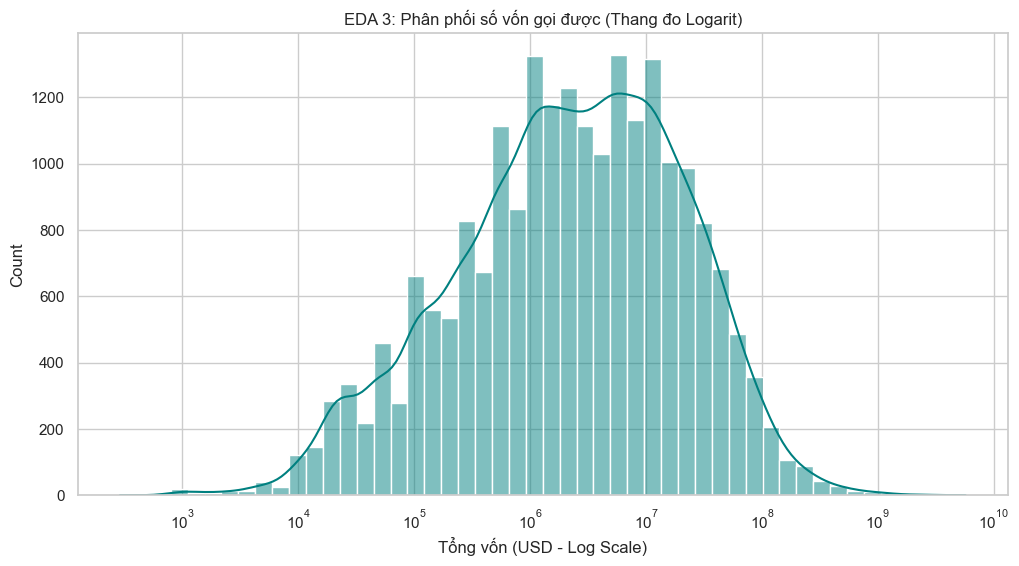

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9188\3551727074.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_funded, x='status', y='total_raised_usd', palette='Set2', showfliers=False)


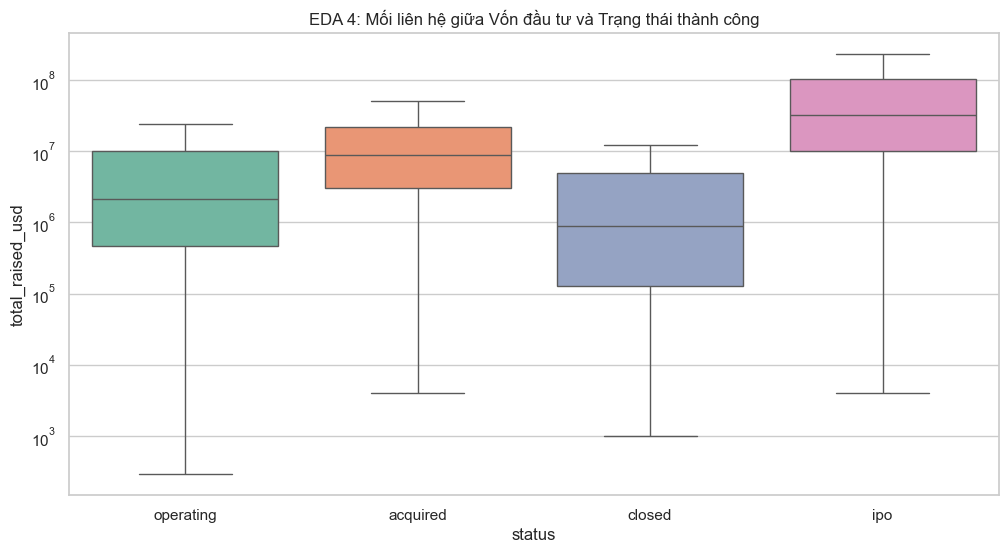

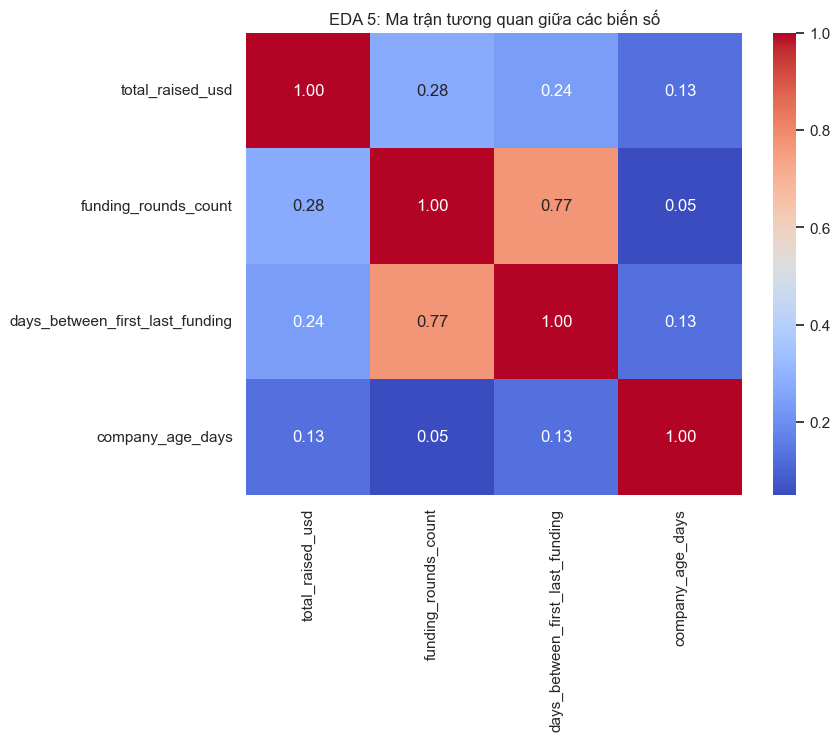

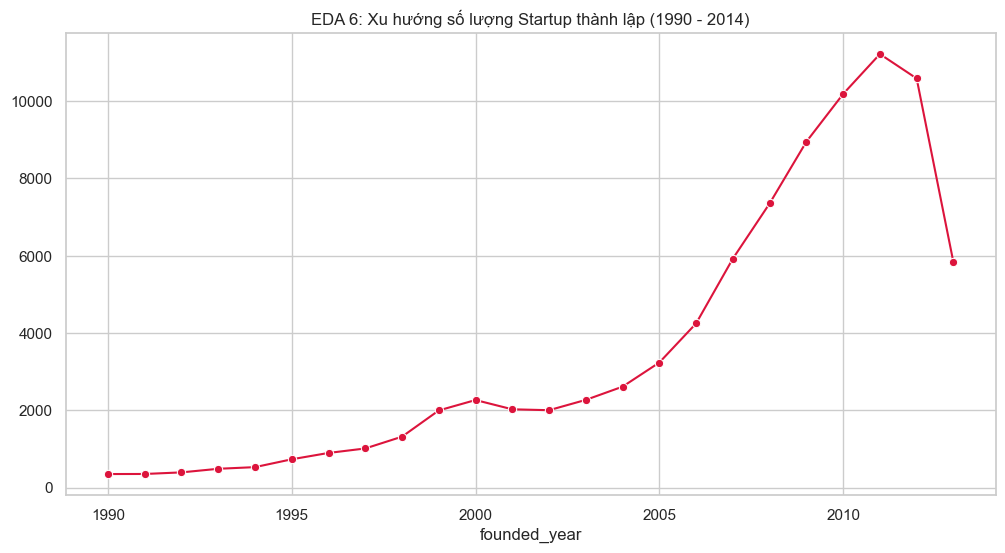

In [2]:
# =============================================================================
# PHẦN 2: ĐỌC FILE ĐÃ GỘP & THỰC HIỆN PHÂN TÍCH (EDA + CLUSTERING)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. ĐỌC DỮ LIỆU TỪ FILE MỚI TẠO
print("📂 ĐANG ĐỌC FILE 'startup_data_merged.csv'...")
try:
    df = pd.read_csv('startup_data_merged.csv') # <--- SỬ DỤNG FILE MỚI TẠI ĐÂY
    print(f"✅ Đã tải xong. Sẵn sàng phân tích {len(df)} dòng dữ liệu.")
except FileNotFoundError:
    print("❌ Lỗi: Chưa tìm thấy file. Hãy chạy PHẦN 1 trước.")
    exit()

# ==========================================
# A. PHÂN TÍCH KHÁM PHÁ (FULL EDA 6 BIỂU ĐỒ)
# ==========================================
print("\n📊 ĐANG VẼ 6 BIỂU ĐỒ EDA...")

# BIỂU ĐỒ 1: PHÂN PHỐI TRẠNG THÁI
plt.figure(figsize=(10, 6))
status_counts = df['status'].value_counts(normalize=True) * 100
ax = sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')
for i, v in enumerate(status_counts.values):
    ax.text(i, v + 0.5, f"{v:.1f}%", ha='center')
plt.title('EDA 1: Tỷ lệ các trạng thái hoạt động của Startup')
plt.show()

# BIỂU ĐỒ 2: TOP 10 LĨNH VỰC
plt.figure(figsize=(12, 6))
top_categories = df['category_code'].value_counts().nlargest(10).index
sns.countplot(data=df, y='category_code', order=top_categories, palette='magma')
plt.title('EDA 2: Top 10 Lĩnh vực (Category) phổ biến nhất')
plt.show()

# (Chuẩn bị dữ liệu tài chính - Chỉ lấy công ty có vốn > 0)
df_funded = df[df['total_raised_usd'] > 0].copy()

# BIỂU ĐỒ 3: PHÂN PHỐI VỐN (HISTOGRAM)
plt.figure(figsize=(12, 6))
sns.histplot(df_funded['total_raised_usd'], bins=50, kde=True, log_scale=True, color='teal')
plt.title('EDA 3: Phân phối số vốn gọi được (Thang đo Logarit)')
plt.xlabel('Tổng vốn (USD - Log Scale)')
plt.show()

# BIỂU ĐỒ 4: TƯƠNG QUAN VỐN & TRẠNG THÁI (BOXPLOT)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_funded, x='status', y='total_raised_usd', palette='Set2', showfliers=False)
plt.yscale('log')
plt.title('EDA 4: Mối liên hệ giữa Vốn đầu tư và Trạng thái thành công')
plt.show()

# BIỂU ĐỒ 5: MA TRẬN TƯƠNG QUAN (HEATMAP)
corr_cols = ['total_raised_usd', 'funding_rounds_count', 'days_between_first_last_funding', 'company_age_days']
plt.figure(figsize=(8, 6))
sns.heatmap(df_funded[corr_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('EDA 5: Ma trận tương quan giữa các biến số')
plt.show()

# BIỂU ĐỒ 6: XU HƯỚNG THEO THỜI GIAN
# Cần chuyển lại sang datetime vì khi đọc từ csv nó là string
df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
df['founded_year'] = df['founded_at'].dt.year
trend_data = df[(df['founded_year'] >= 1990) & (df['founded_year'] <= 2014)]['founded_year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=trend_data.index, y=trend_data.values, marker='o', color='crimson')
plt.title('EDA 6: Xu hướng số lượng Startup thành lập (1990 - 2014)')
plt.show()



🤖 [B] PHÂN CỤM STARTUP (K-MEANS)
⚙️ Đang tính toán Elbow & Silhouette...


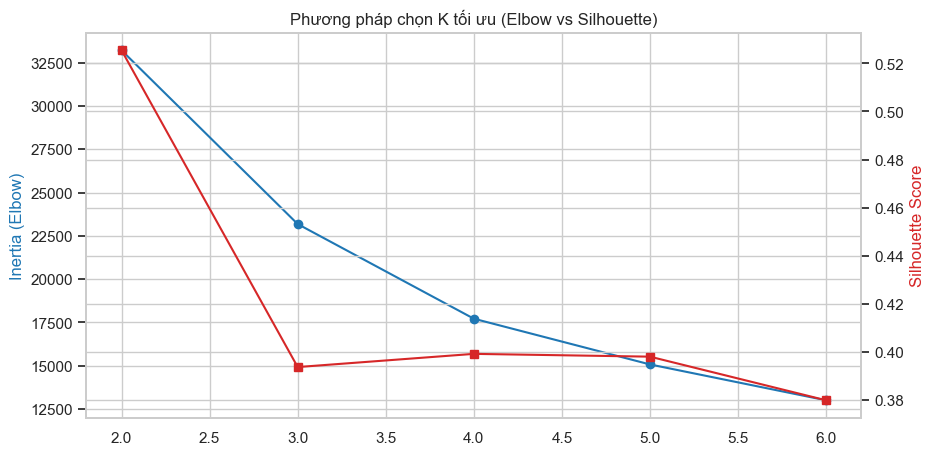

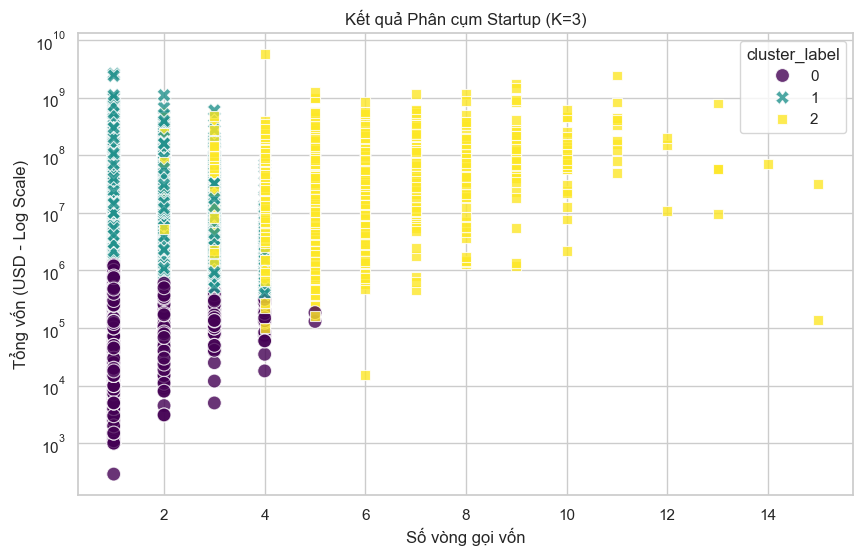


📝 NHẬN XÉT KẾT QUẢ PHÂN CỤM:
   Dựa trên dữ liệu, thuật toán đã chia các Startup thành 3 nhóm đặc trưng:
   👉 Nhóm 1 (Startups Nhỏ/Mới): Vốn trung bình ~$386,137. Thường đang ở giai đoạn Seed.
   👉 Nhóm 2 (Startups Tăng trưởng): Vốn trung bình ~$14,459,785. Đã có chỗ đứng trên thị trường.
   👉 Nhóm 3 (Kỳ lân/Unicorns): Vốn trung bình ~$49,601,421. Nhóm tinh hoa gọi vốn khổng lồ.

🔮 [C] PHÂN LỚP: DỰ BÁO THÀNH CÔNG (RANDOM FOREST)

📊 ĐỘ CHÍNH XÁC CỦA MÔ HÌNH: 88.61%


C:\Users\ASUS\AppData\Local\Temp\ipykernel_9188\2002585897.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_imp.values, y=feature_imp.index, palette='magma')


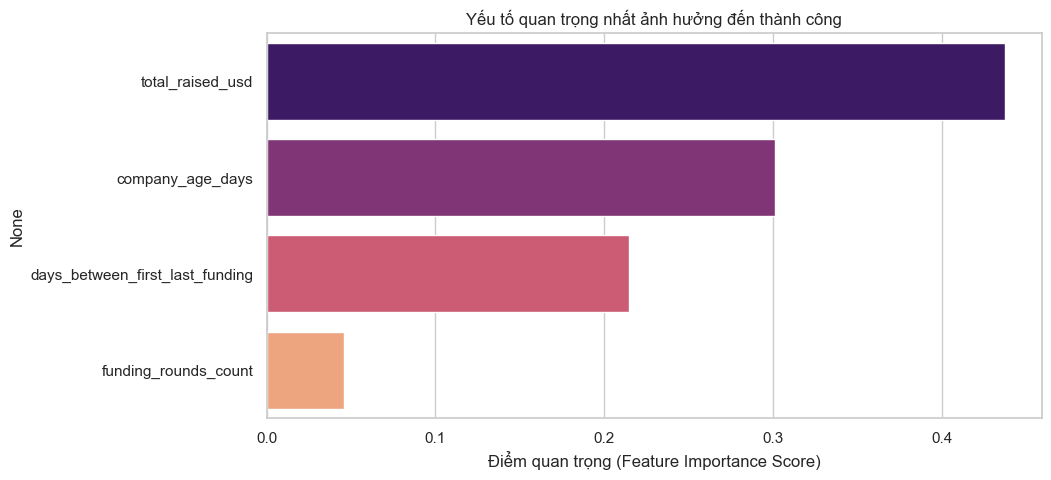


📝 NHẬN XÉT VỀ YẾU TỐ QUYẾT ĐỊNH:
   - Mô hình Random Forest cho thấy 'total_raised_usd' là yếu tố quan trọng nhất để dự báo thành công.
   - Độ chính xác 88.61% cho thấy mô hình hoạt động hiệu quả.


In [3]:
# =============================================================================
# B. PHÂN CỤM (CLUSTERING) & NHẬN XÉT
# =============================================================================
print("\n" + "="*40)
print("🤖 [B] PHÂN CỤM STARTUP (K-MEANS)")
print("="*40)

# 1. Chuẩn bị dữ liệu
df_ml = df[
    (df['total_raised_usd'] > 0) & 
    (df['funding_rounds_count'] > 0) &
    (df['days_between_first_last_funding'].notna())
].copy()

# Feature Engineering
df_ml['log_raised_amount'] = np.log1p(df_ml['total_raised_usd'])
features_cluster = ['log_raised_amount', 'funding_rounds_count', 'days_between_first_last_funding']

# Chuẩn hóa
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df_ml[features_cluster])

# 2. Tìm K tối ưu (Vẽ Elbow & Silhouette)
inertia = []
silhouette_scores = []
K_range = range(2, 7)

print("⚙️ Đang tính toán Elbow & Silhouette...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, labels))

# Vẽ biểu đồ chọn K
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(K_range, inertia, marker='o', color='tab:blue', label='Inertia')
ax1.set_ylabel('Inertia (Elbow)', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(K_range, silhouette_scores, marker='s', color='tab:red', label='Silhouette')
ax2.set_ylabel('Silhouette Score', color='tab:red')
plt.title('Phương pháp chọn K tối ưu (Elbow vs Silhouette)')
plt.show()

# 3. Chạy K-Means (Chọn K=3)
k_final = 3
kmeans = KMeans(n_clusters=k_final, random_state=42, n_init=10)
df_ml['cluster_label'] = kmeans.fit_predict(X_cluster)

# 4. Vẽ kết quả Phân cụm
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_ml, x='funding_rounds_count', y='total_raised_usd', hue='cluster_label', 
    palette='viridis', style='cluster_label', s=100, alpha=0.8
)
plt.yscale('log')
plt.title(f'Kết quả Phân cụm Startup (K={k_final})')
plt.xlabel('Số vòng gọi vốn')
plt.ylabel('Tổng vốn (USD - Log Scale)')
plt.show()

# --- NHẬN XÉT TỰ ĐỘNG PHÂN CỤM ---
cluster_stats = df_ml.groupby('cluster_label')[['total_raised_usd', 'funding_rounds_count']].mean()
sorted_idx = cluster_stats.sort_values('total_raised_usd').index

print(f"\n📝 NHẬN XÉT KẾT QUẢ PHÂN CỤM:")
print(f"   Dựa trên dữ liệu, thuật toán đã chia các Startup thành 3 nhóm đặc trưng:")
print(f"   👉 Nhóm 1 (Startups Nhỏ/Mới): Vốn trung bình ~${cluster_stats.loc[sorted_idx[0], 'total_raised_usd']:,.0f}. Thường đang ở giai đoạn Seed.")
print(f"   👉 Nhóm 2 (Startups Tăng trưởng): Vốn trung bình ~${cluster_stats.loc[sorted_idx[1], 'total_raised_usd']:,.0f}. Đã có chỗ đứng trên thị trường.")
print(f"   👉 Nhóm 3 (Kỳ lân/Unicorns): Vốn trung bình ~${cluster_stats.loc[sorted_idx[-1], 'total_raised_usd']:,.0f}. Nhóm tinh hoa gọi vốn khổng lồ.")

# =============================================================================
# C. PHÂN LỚP (CLASSIFICATION) & NHẬN XÉT
# =============================================================================
print("\n" + "="*40)
print("🔮 [C] PHÂN LỚP: DỰ BÁO THÀNH CÔNG (RANDOM FOREST)")
print("="*40)

# 1. Tạo biến mục tiêu (1: Thành công, 0: Khác)
df_ml['is_successful'] = df_ml['status'].apply(lambda x: 1 if x in ['ipo', 'acquired'] else 0)

# 3. Chuẩn bị dữ liệu để Train
features_class = ['total_raised_usd', 'funding_rounds_count', 'days_between_first_last_funding', 'company_age_days']
X = df_ml[features_class]
y = df_ml['is_successful']

# 4. Chia tập Train/Test (80% học, 20% thi)
# Hàm này giờ sẽ chạy được vì đã import ở trên
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Huấn luyện mô hình
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# 6. Đánh giá kết quả
acc = accuracy_score(y_test, y_pred)
print(f"\n📊 ĐỘ CHÍNH XÁC CỦA MÔ HÌNH: {acc:.2%}")

# 7. Biểu đồ Feature Importance (Yếu tố quan trọng nhất)
feature_imp = pd.Series(rf_model.feature_importances_, index=features_class).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_imp.values, y=feature_imp.index, palette='magma')
plt.title('Yếu tố quan trọng nhất ảnh hưởng đến thành công')
plt.xlabel('Điểm quan trọng (Feature Importance Score)')
plt.show()

# --- NHẬN XÉT TỰ ĐỘNG ---
top_feature = feature_imp.index[0]
print(f"\n📝 NHẬN XÉT VỀ YẾU TỐ QUYẾT ĐỊNH:")
print(f"   - Mô hình Random Forest cho thấy '{top_feature}' là yếu tố quan trọng nhất để dự báo thành công.")
print(f"   - Độ chính xác {acc:.2%} cho thấy mô hình hoạt động hiệu quả.")